In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
delta_t = 0.01

In [3]:
columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az', 'roll', 'pitch', 'yaw']
data = []
with open('./roll_pitch_conversion_2.txt', 'r') as f:
    data = [l.strip()[:-1] for l in f.readlines() if len(l.strip()) > 0]
data = [[float(_d) for _d in d.split(',')] for d in data]
data = np.array(data)
df_raw_data = pd.DataFrame(data=data, columns=columns)
df_raw_data

,gx,gy,gz,ax,ay,az,roll,pitch,yaw
0,-0.61,0.32,-0.72,0.25,-0.07,9.69,0.31,-0.30,0.06
1,-0.72,0.56,-0.02,0.29,-0.11,9.70,0.29,-0.29,0.06
2,-0.84,0.40,0.40,0.32,-0.06,9.63,0.28,-0.29,0.06
3,-0.60,0.41,0.56,0.32,-0.05,9.69,0.27,-0.29,0.06
4,-0.76,0.66,0.15,0.30,0.10,9.65,0.26,-0.29,0.07
...,...,...,...,...,...,...,...,...,...
1749,-0.66,0.53,0.11,0.22,-0.06,9.65,-1.98,-0.31,-18.60
1750,-0.63,0.53,0.08,0.23,-0.09,9.63,-1.98,-0.31,-18.59
1751,-0.69,0.52,0.11,0.21,-0.05,9.58,-1.98,-0.30,-18.58
1752,-0.70,0.49,0.18,0.22,-0.06,9.65,-1.98,-0.30,-18.57


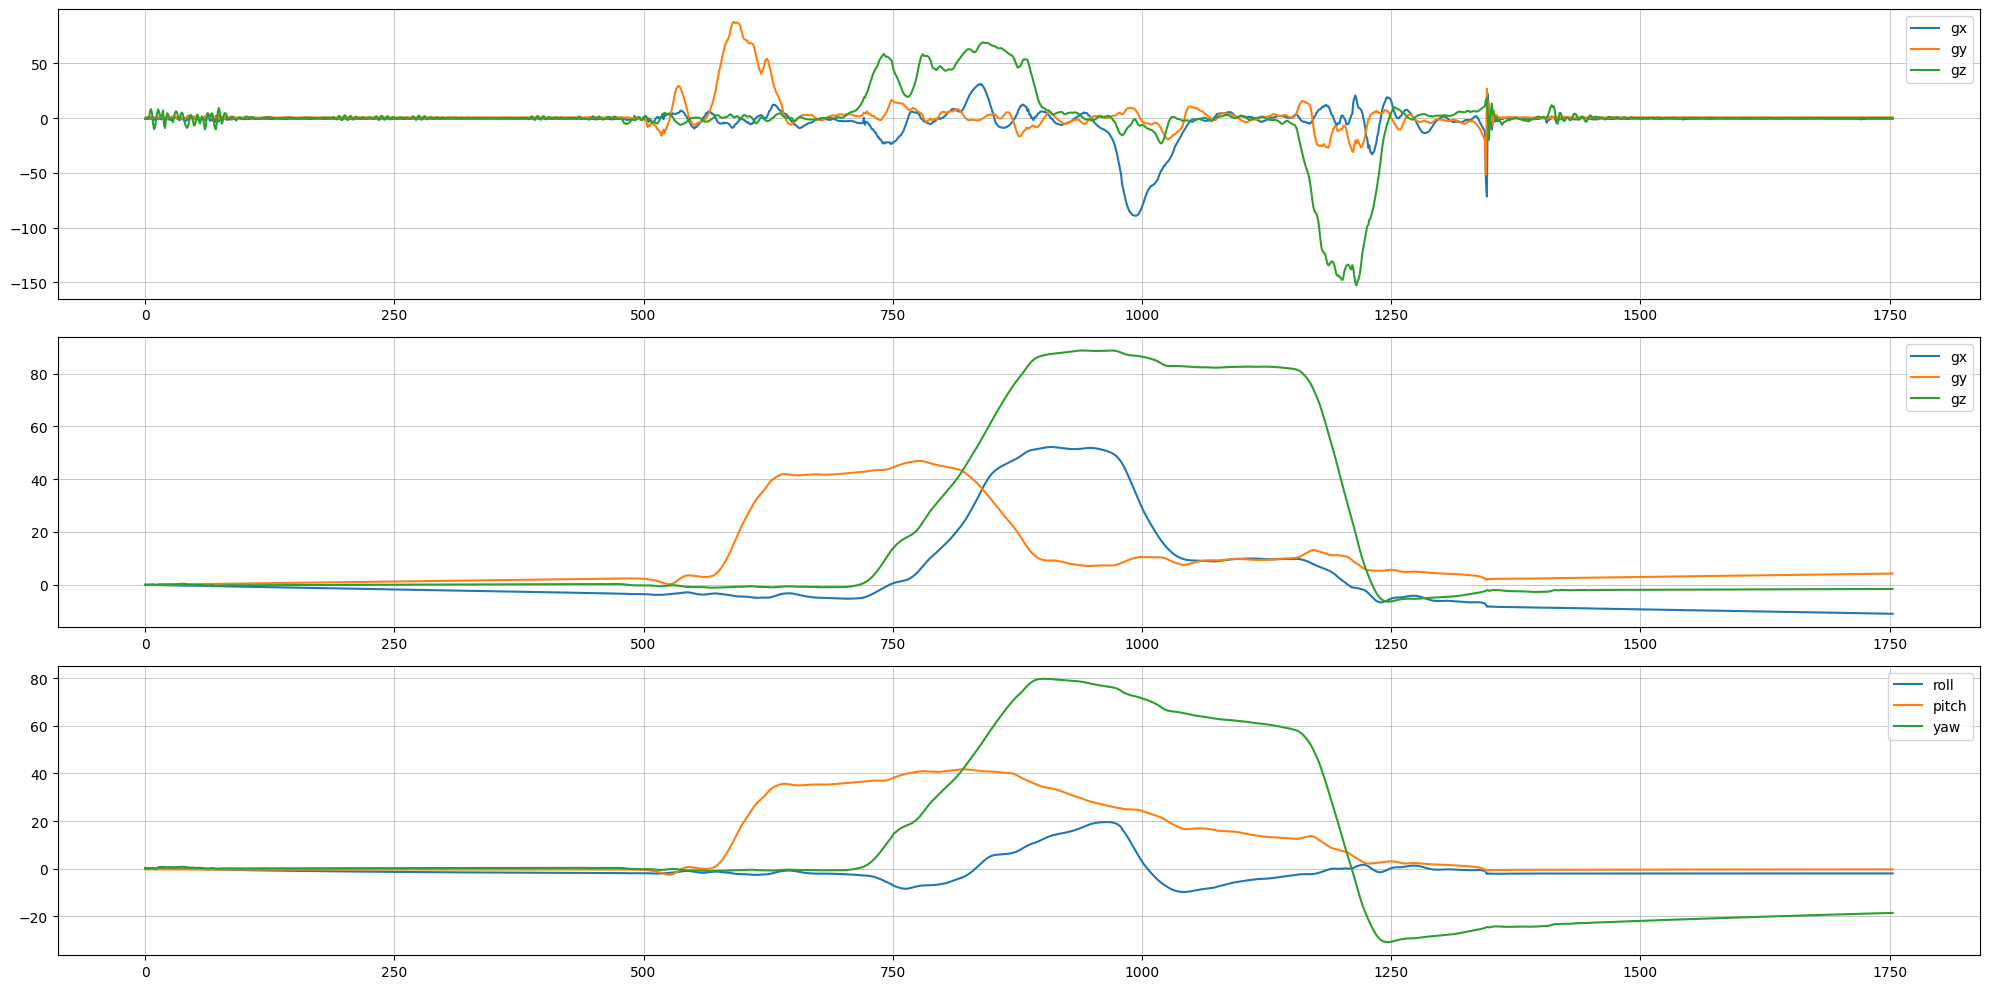

In [4]:
angle_from_gyro_data = [[0,0,0]]
for d in df_raw_data[['gx', 'gy', 'gz']].values:
    roll = angle_from_gyro_data[-1][0] + d[0] * delta_t
    pitch = angle_from_gyro_data[-1][1] + d[1] * delta_t
    yaw = angle_from_gyro_data[-1][2] + d[2] * delta_t
    
    # Apply the transformation for pitch to roll during yaw
    new_pitch = -roll * np.sin(d[2] * delta_t * np.pi / 180) + pitch * np.cos(d[2] * delta_t * np.pi / 180)
    new_roll = roll * np.cos(d[2] * delta_t * np.pi / 180) + pitch * np.sin(d[2] * delta_t * np.pi / 180)
    
    angle_from_gyro_data.append([new_roll, new_pitch, yaw])
    
angle_from_gyro_data = np.array(angle_from_gyro_data[1:])


plt.figure(figsize=(20,10))

columns_to_plot = ['gx', 'gy', 'gz']
plt.subplot(3,1,1)
plt.plot(df_raw_data[columns_to_plot])
plt.legend(columns_to_plot)
plt.grid(which='both', linewidth=0.5)

columns_to_plot = ['gx', 'gy', 'gz']
plt.subplot(3,1,2)
plt.plot(angle_from_gyro_data)
plt.legend(columns_to_plot)
plt.grid(which='both', linewidth=0.5)

columns_to_plot = ['roll', 'pitch', 'yaw']
plt.subplot(3,1,3)
plt.plot(df_raw_data[columns_to_plot])
plt.legend(columns_to_plot)
plt.grid(which='both', linewidth=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

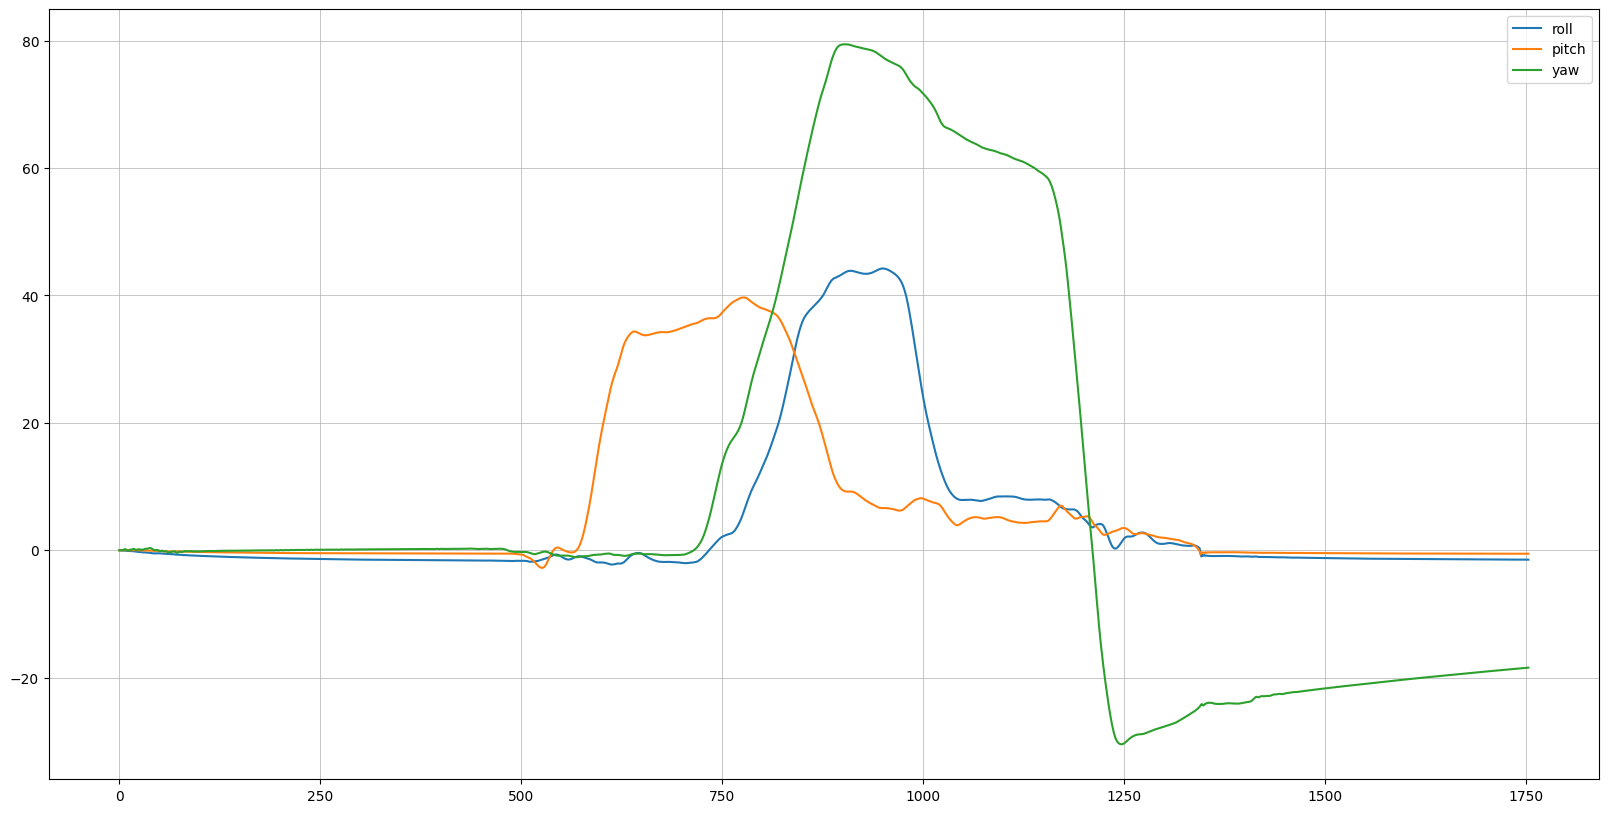

In [5]:
# state = np.array([0,0,0]).reshape(-1,1)
# P = np.eye(3)
# Q = np.diag([0.01, 0.01, 0.00])
# R = np.diag([0.1, 0.1, 0.1])
# prev_accel_angle = np.array([0,0,0]).reshape(-1,1)
# alpha = 0.96


class ExtendedKalmanFilter:

    def __init__(self, P, Q, R, alpha):
        self.state = np.array([0,0,0]).reshape(-1,1)
        self.P = P
        self.Q = Q
        self.R = R
        self.prev_accel_angle = np.array([0,0,0]).reshape(-1,1)
        self.alpha = alpha
    
    def ekf_update(self, gyro, accl_angle):
        self.state = self.state + gyro * delta_t
        self.P = self.P + self.Q
    
        # # accl_angle =  self.prev_accel_angle*self.alpha + (1 - self.alpha)*accl_angle
        # accl_angle = (1 - self.alpha) * self.prev_accel_angle + self.alpha*accl_angle
        # self.prev_accel_angle = accl_angle
        # residual = accl_angle - self.state
        
        # K = self.P.dot(np.linalg.inv(self.P + self.R))
        # self.state = self.state + K.dot(residual)
        # self.P = (np.eye(3) - K).dot(self.P)
        # return self.state

        # Apply roll to pitch conversion during yaw
        yaw = self.state[2, 0]
        roll = self.state[0, 0]
        pitch = self.state[1, 0]
        
        # filter_tmp_f_1 = -roll * np.sin(np.deg2rad(gyro[2][0]) * delta_t) + pitch * np.cos(np.deg2rad(gyro[2][0]) * delta_t)
        # filter_tmp_f_2 =  roll * np.cos(np.deg2rad(gyro[2][0]) * delta_t) + pitch * np.sin(np.deg2rad(gyro[2][0]) * delta_t)
        filter_tmp_f_1 = pitch - roll * np.sin(np.deg2rad(gyro[2][0]) * delta_t)
        filter_tmp_f_2 = roll + pitch * np.sin(np.deg2rad(gyro[2][0]) * delta_t)
        
        self.state[1, 0] = filter_tmp_f_1  # Update pitch
        self.state[0, 0] = filter_tmp_f_2  # Update roll
        
        
        self.P = self.P + self.Q
        
        # Convert accelerometer angles using complementary filter
        accl_angle = (1 - self.alpha) * self.prev_accel_angle + self.alpha * accl_angle
        self.prev_accel_angle = accl_angle

        # Measurement update
        residual = accl_angle - self.state
        K = self.P.dot(np.linalg.inv(self.P + self.R))
        self.state = self.state + K.dot(residual)
        
        self.P = (np.eye(3) - K).dot(self.P)
        return self.state

    
# P = np.eye(3)
P = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])
# Q = np.diag([0.02318644, 0.02318644, 0.0])
Q = np.diag([0.002, 0.002, 0.0])
R = np.diag([100, 100, 100])
alpha = 0.04



ekf = ExtendedKalmanFilter(P, Q, R, alpha)

ekf_states = []

for i in range(df_raw_data.shape[0]):
    row = df_raw_data.iloc[i]
    gyro_data = row[['gx', 'gy', 'gz']].values.reshape(-1,1)
    accl_data = row[['ax', 'ay', 'az']].values
    accl_angle = np.rad2deg(np.array([
        np.arctan(accl_data[1] / np.sqrt(accl_data[0]**2 + accl_data[2]**2)),
        np.arctan(-accl_data[0] / np.sqrt(accl_data[1]**2 + accl_data[2]**2)),
        0
    ]))
    accl_angle = accl_angle.reshape(-1,1)
    updated_state = ekf.ekf_update(gyro_data, accl_angle)
    ekf_states.append(updated_state.reshape(3))

ekf_states = pd.DataFrame(data=np.array(ekf_states), columns=['x', 'y', 'z'])

plot_data = [
    # [df_gyro_angle['x'], 'gyro'],
    [ekf_states['x'], 'roll'],
    [ekf_states['y'], 'pitch'],
    [ekf_states['z'], 'yaw'],
    # [df_raw_data['angy'], 'received angx'],
    # [df_raw_data['pidx'], 'pidx']
]

plt.figure(figsize=(20, 10))
for d, _ in plot_data:
    plt.plot(d)

plt.legend([p[1] for p in plot_data])

plt.grid(which='both', linewidth=0.5)
plt.show()
